In [3]:
import numpy as np
import os
import pickle
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

In [4]:
BASE_DIR='/kaggle/input/flickr8k'
WORKING_DIR='/kaggle/working'

## Extract Image features

In [5]:
# load VGG16 model
model = VGG16()
#restructure the model
model=Model(inputs=model.inputs,outputs=model.layers[-2].output)
#summarize
print(model.summary())

2023-02-06 02:26:43.773455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 02:26:43.774375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 02:26:43.896765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 02:26:43.897561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 02:26:43.898270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

553476096/553467096 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [6]:
# extract features from image
features={}
directory = os.path.join(BASE_DIR,'Images')
for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path=directory+'/'+img_name
    image=load_img(img_path,target_size=(224,224))
    # convert image pixels to numpy array
    image=img_to_array(image)
    #reshape data for model
    image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    #preprocess image for vgg
    image=preprocess_input(image)
    #extract features 
    feature=model.predict(image,verbose=0)
    #get image id
    image_id=img_name.split('.')[0]
    #store feature
    features[image_id]=feature

  0%|          | 0/8091 [00:00<?, ?it/s]

2023-02-06 02:26:51.932079: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-06 02:26:53.336867: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [7]:
# store features in pickle
pickle.dump(features,open(os.path.join(WORKING_DIR,'features.pkl'),'wb'))

In [8]:
#load features from pickle
with open('/kaggle/working/features.pkl','rb') as f:
    features=pickle.load(f)

## Load the captions data

In [9]:
with open(os.path.join(BASE_DIR,'captions.txt'),'r') as f:
    next(f)
    captions_doc=f.read()

In [10]:
# create mapping of image to captions
mapping={}
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens=line.split(',')
    if len(line)<2:
        continue
    image_id,caption=tokens[0],tokens[1:]
    # remove extension from image id
    image_id=image_id.split('.')[0]
    #convert caption list to string
    caption=" ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id]=[]
    #store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [11]:
len(mapping)

8091

## Preprocess text data

In [12]:
def clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption=captions[i]
            #preprocessing step
            #convert to lower case
            caption=caption.lower()
            #delete digits, special characters etc
            caption=caption.replace('[^A-Za-z]','')
            #delete additional spaces
            caption=caption.replace('\s+',' ')
            # add start and end tags to the caption
            caption='startseq '+" ".join([word for word in caption.split() if len(word)>1])+' endseq'
            captions[i]=caption

In [13]:
#before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [14]:
#preprocesss the text
clean(mapping)

In [15]:
#after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [16]:
all_captions=[]
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [17]:
len(all_captions)

40455

In [18]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [19]:
# tokenize the text
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1
vocab_size

8485

In [20]:
#get maximum length of the caption available
max_length=max(len(caption.split()) for caption in all_captions)
max_length

35

## Train, Test split

In [21]:
image_ids=list(mapping.keys())
split=int(len(image_ids)*0.90)
train=image_ids[:split]
test=image_ids[split:]

In [22]:
# create data generator to get data in batch(avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):    
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]            
            for caption in captions:   
                #encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]               
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

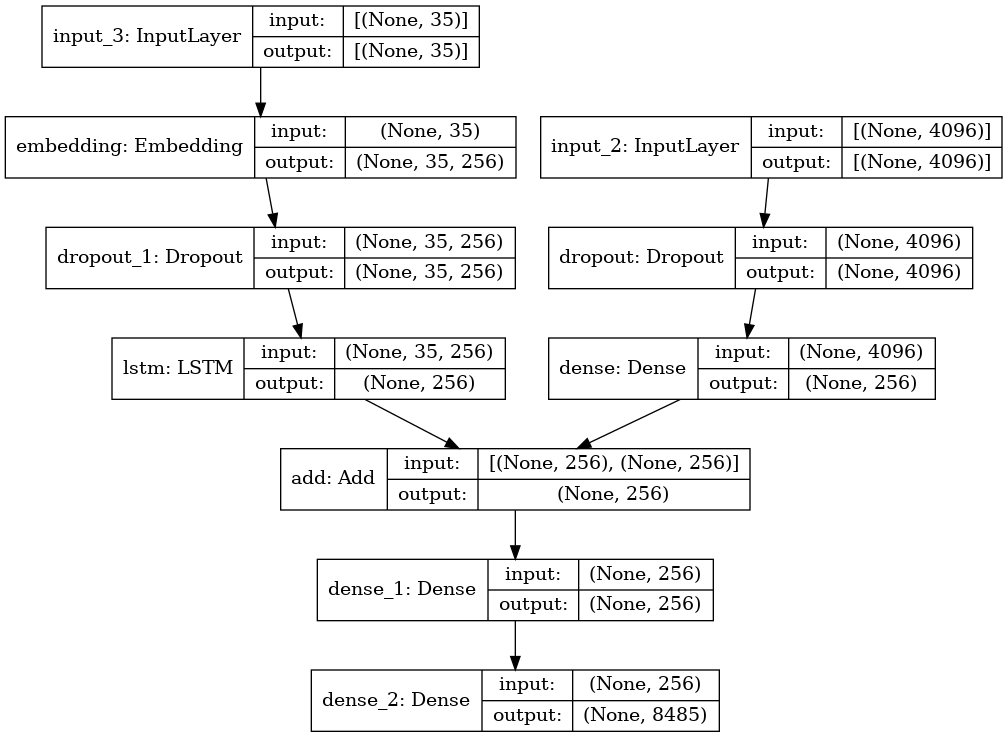

In [23]:
#Encoder Model
#image feature layer
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
#sequence feature layer
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

#Decoder Model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [24]:
#Train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 70s 308ms/step - loss: 2.1775


In [25]:
model.save(WORKING_DIR+'/model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [26]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [34]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break      
    return in_text

In [35]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()
for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)
    
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.536201
BLEU-2: 0.310092


## Visualize the result

In [36]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR,"Images" ,image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq brown and white dog is running through the snow endseq
startseq dog is running in the snow endseq
startseq dog running through snow endseq
startseq white and brown dog is running through snow covered field endseq
startseq the white and brown dog is running over the surface of the snow endseq
--------------------Predicted--------------------
startseq white dog is running through the snow endseq


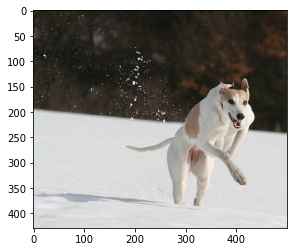

In [37]:
generate_caption("101654506_8eb26cfb60.jpg")

---------------------Actual---------------------
startseq woman crouches near three dogs in field endseq
startseq three dogs are playing on grassy hill with blue sky endseq
startseq three dogs are standing in the grass and person is sitting next to them endseq
startseq three dogs on grassy hill endseq
startseq three dogs stand in grassy field while person kneels nearby endseq
--------------------Predicted--------------------
startseq two dogs are playing in the grass endseq


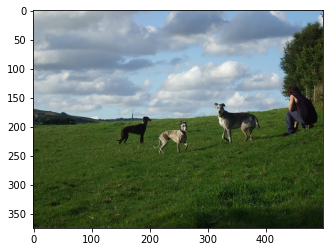

In [38]:
generate_caption("1032122270_ea6f0beedb.jpg")

---------------------Actual---------------------
startseq man drilling hole in the ice endseq
startseq man is drilling through the frozen ice of pond endseq
startseq person in the snow drilling hole in the ice endseq
startseq person standing on frozen lake endseq
startseq two men are ice fishing endseq
--------------------Predicted--------------------
startseq woman drilling in the snow endseq


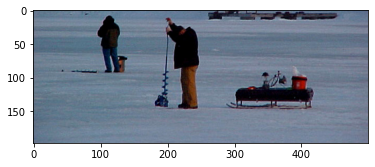

In [39]:
generate_caption("102351840_323e3de834.jpg")

---------------------Actual---------------------
startseq dog prepares to catch thrown object in field with nearby cars endseq
startseq white dog is about to catch yellow ball in its mouth endseq
startseq white dog is about to catch yellow dog toy endseq
startseq white dog is ready to catch yellow ball flying through the air endseq
startseq white dog running after yellow ball endseq
--------------------Predicted--------------------
startseq white dog is running on the grass endseq


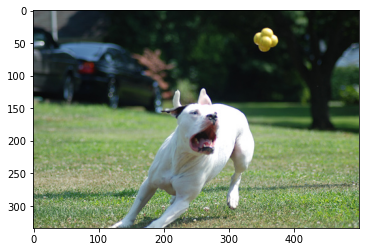

In [40]:
generate_caption("1019604187_d087bf9a5f.jpg")